In [ ]:
# what we need:
# - motion corrected runs read into arrays
# - design matrices for each run, where
#     - len of design matrix equals len of fMRI run
#     - each image / image-location is a different condition
#     - start of trial is marked with 1 in the design

In [1]:
import nibabel as nib
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import os.path as op
import time
import urllib.request
from tqdm import tqdm # progress bars
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

from glmsingle.glmsingle import GLM_single

In [2]:
base_folder = op.join('D:\\', 'Zsuzsa', 'HCCCL', 'miniTRK', 'Results')
mri_folder = op.join(base_folder, '01_MRI', 'fMRI_Preproc', 'VER3', 'aligned')
design_folder = op.join(base_folder, '02_APS_MRI_Logs', 'single_trials')
subj = '351677'
task = 'OBJ'
acq = 'ENC'
#r = '1'
#nii_file = subj + '_' + task + '_' + acq + '_' + r + '_To_ObjEnc1MeanFunc.nii.gz'
#fname = op.join(mri_folder, nii_file)

In [ ]:
img = nib.load(fname)
print(img.shape)
print(img.header)

In [3]:
# load runs and design files
data = []
designs = []
for r in ['1','2']:
    nii_file = subj + '_' + task + '_' + acq + '_' + r + '_To_ObjEnc1MeanFunc_Upsampled.nii.gz'
    fname = op.join(mri_folder, nii_file)
    img = nib.load(fname)
    data.append(img.get_fdata())
    
    design_file =  subj + '_' + task + '_SingleTrials_run_' + r + '_Upsampled.csv' 
    fname = op.join(design_folder, design_file)
    design = pd.read_csv(fname).to_numpy()
    designs.append(design)

In [4]:
designs[0].shape

(460, 543)

In [5]:
data[0].shape

(136, 136, 80, 460)

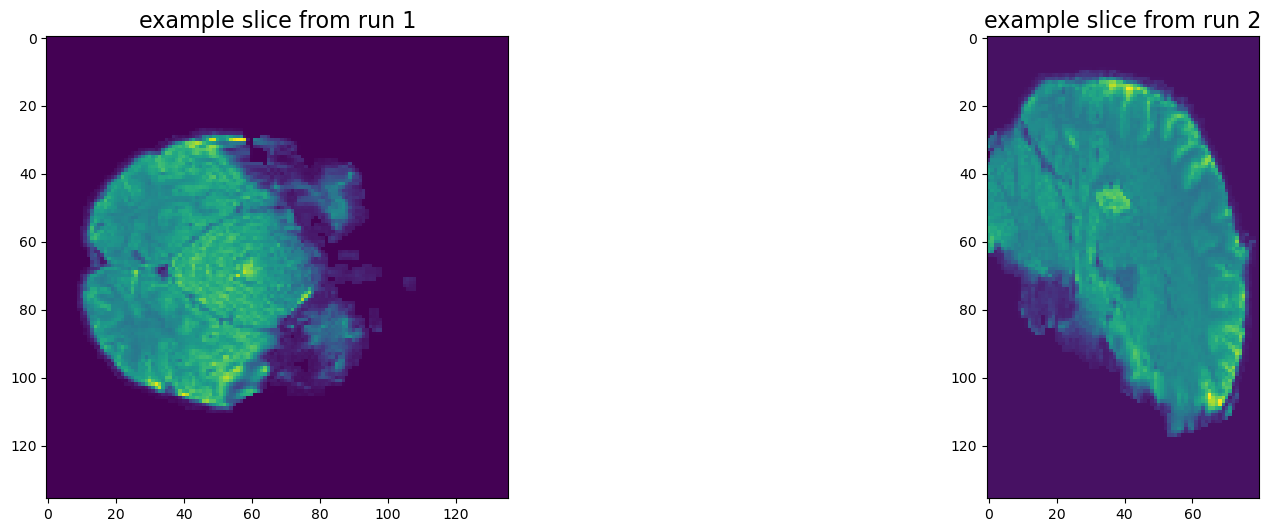

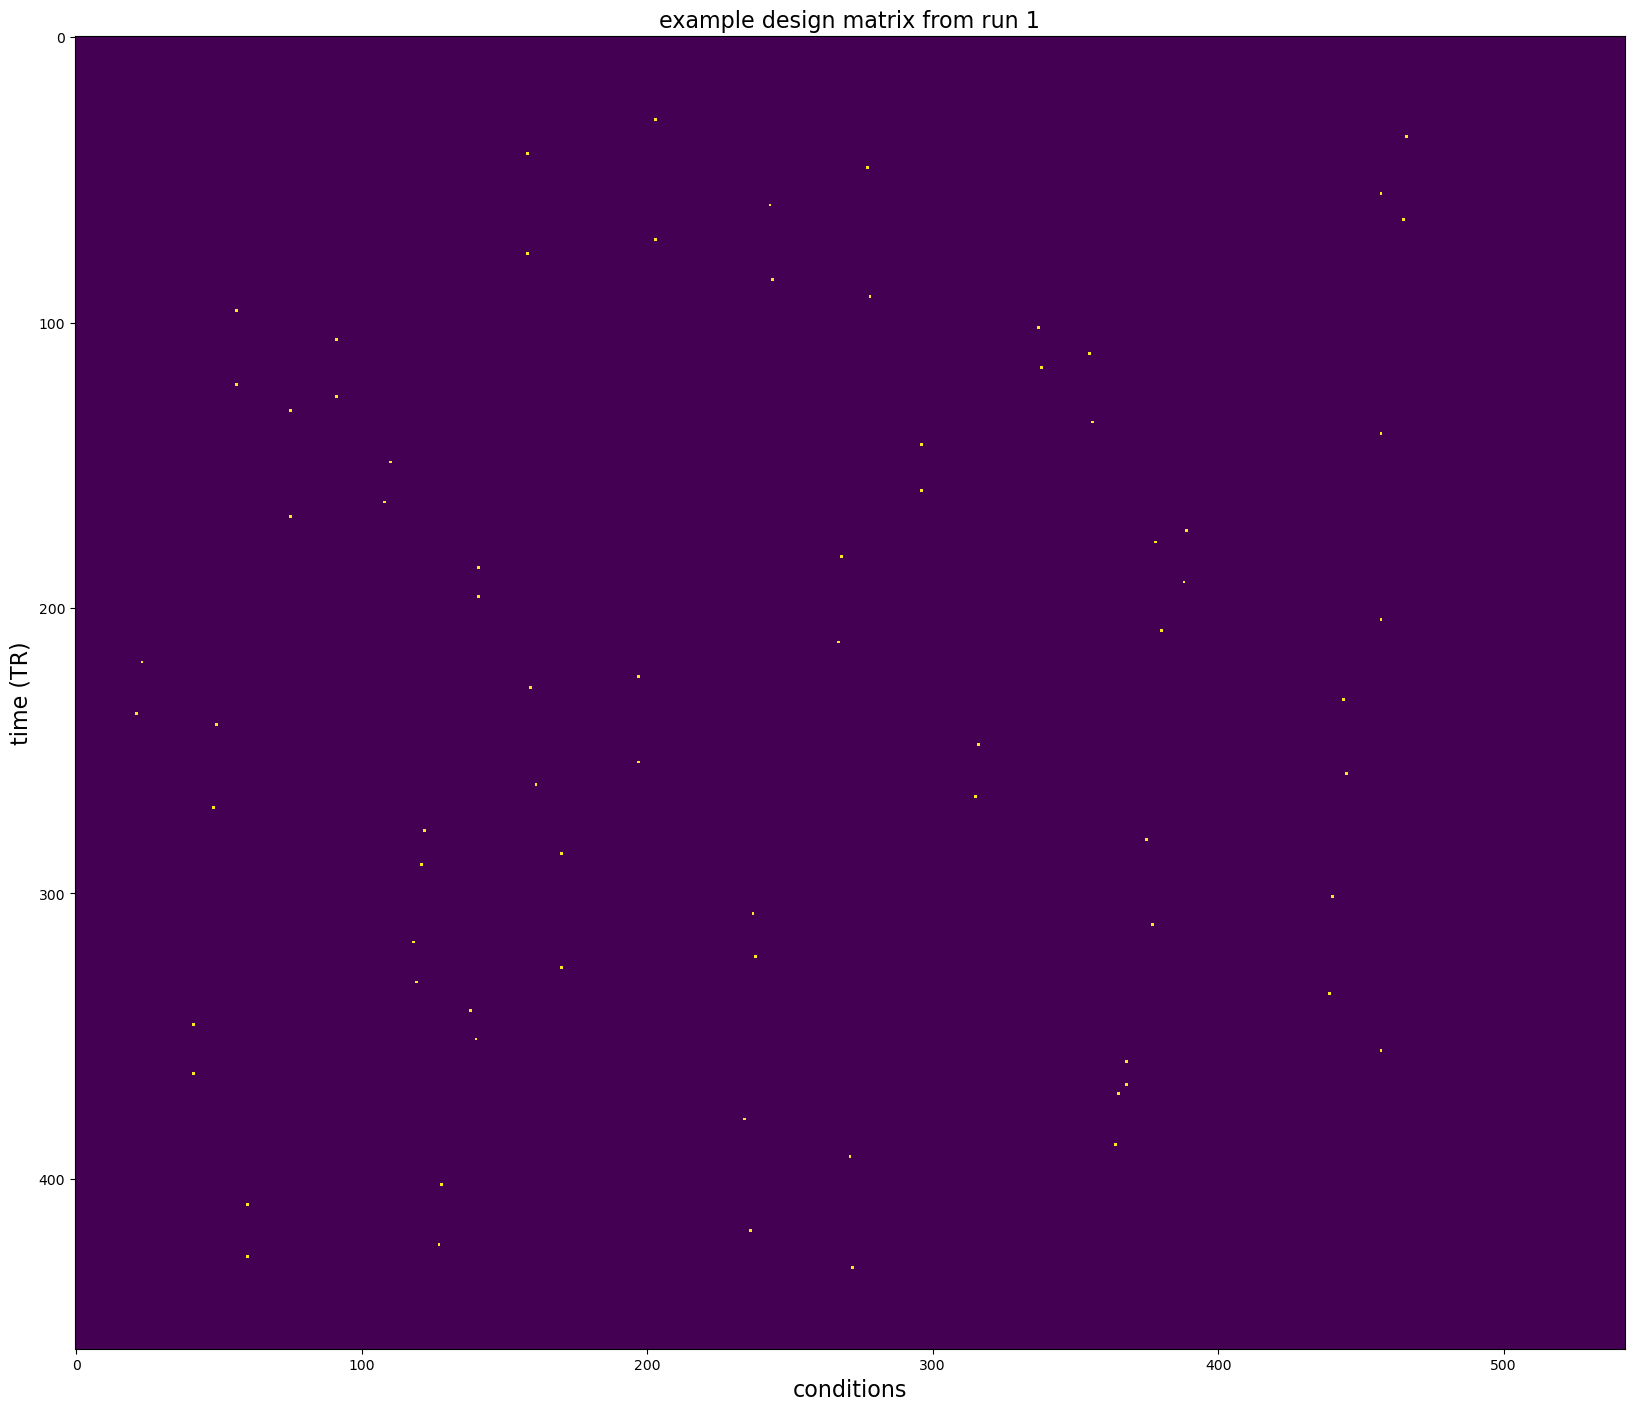

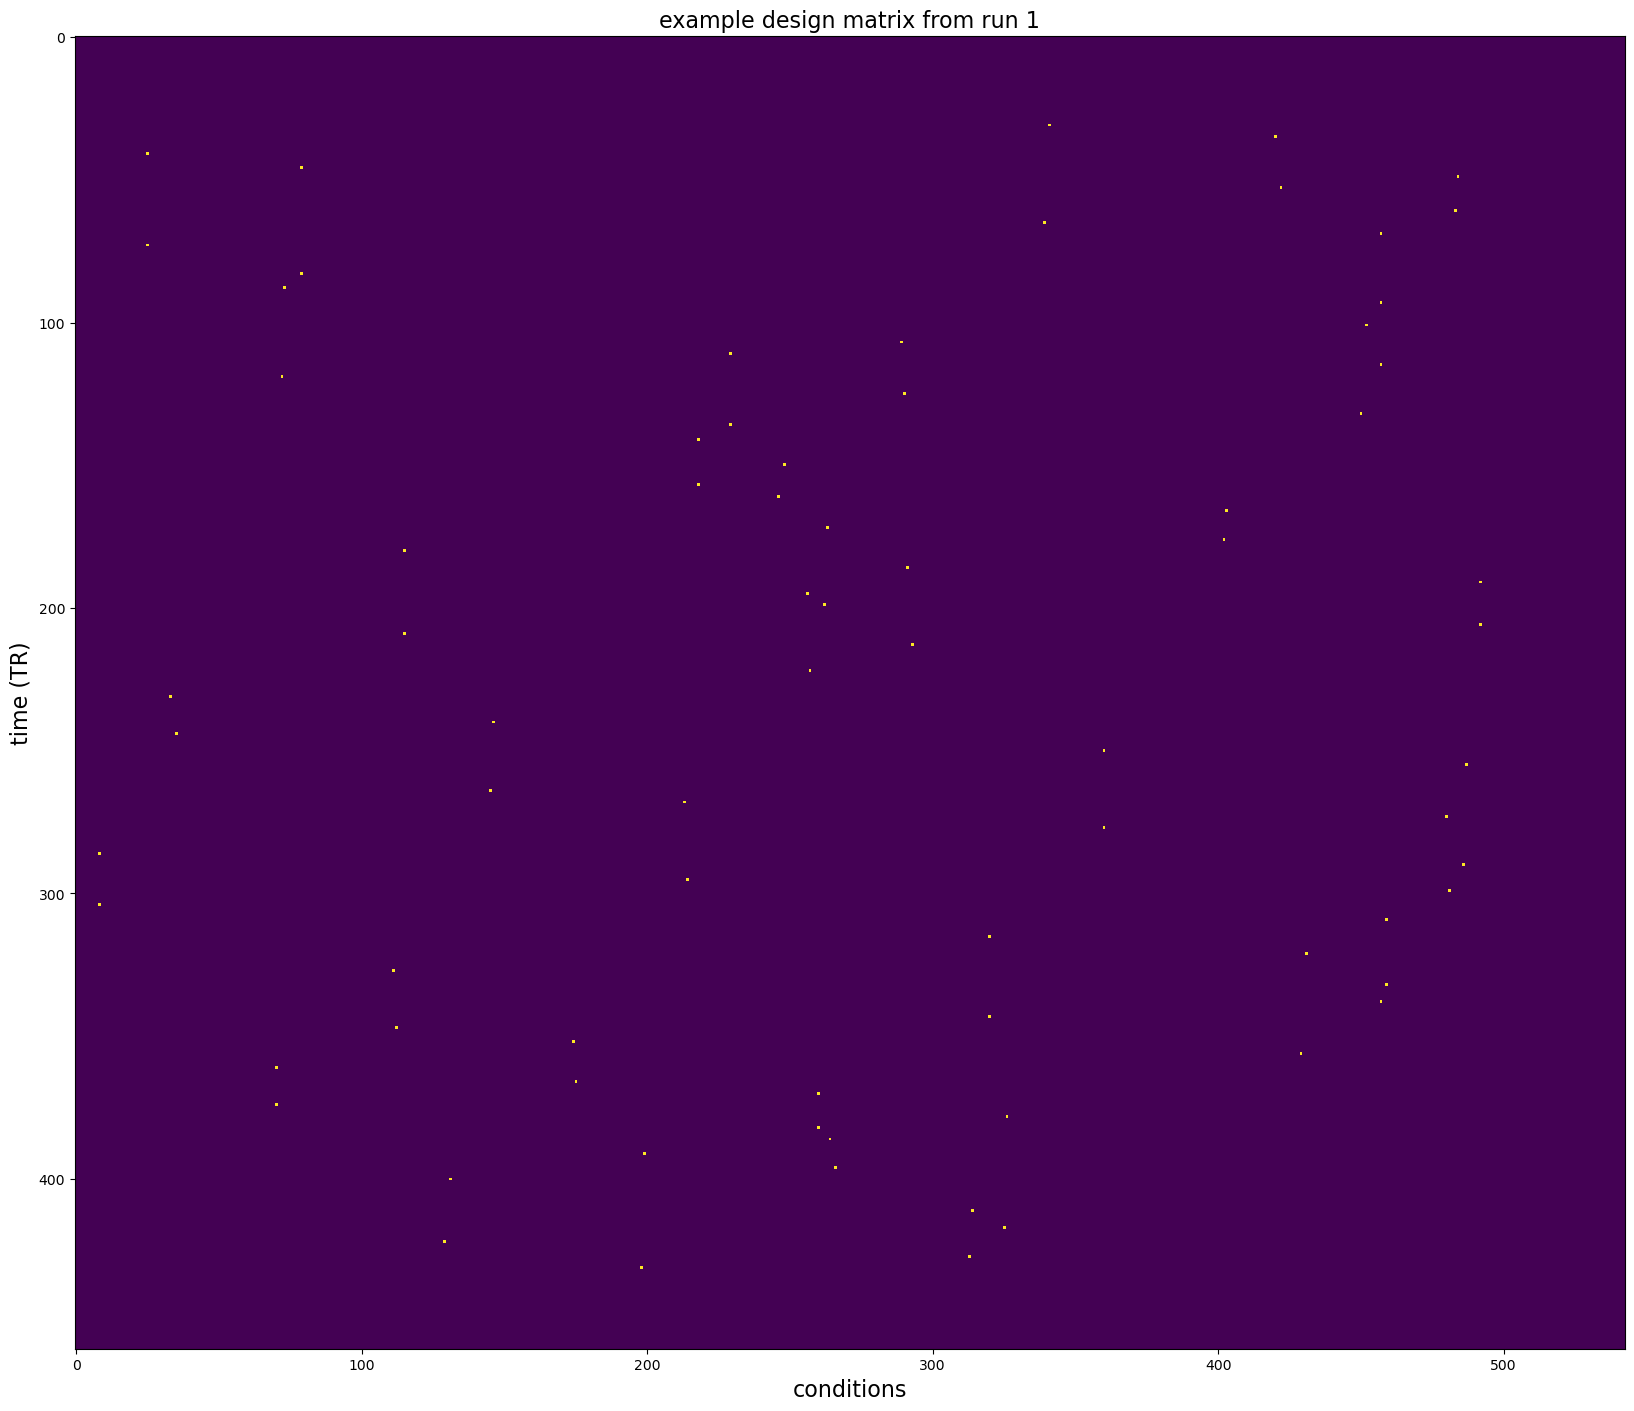

In [6]:
# plot example slice from run 1
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(data[0][:,:,22,0])
plt.title('example slice from run 1',fontsize=16)
plt.subplot(122)
plt.imshow(data[1][55,:,:,0])
plt.title('example slice from run 2',fontsize=16)

# plot design matrix from run 1
plt.figure(figsize=(20,20))
plt.imshow(designs[0][:,:],interpolation='none')
plt.title('example design matrix from run 1',fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16);

# plot design matrix from run 2
plt.figure(figsize=(20,20))
plt.imshow(designs[1][:,:],interpolation='none')
plt.title('example design matrix from run 1',fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16);

# create a directory for saving GLMsingle outputs
outputdir_glmsingle = op.join(base_folder,'01_MRI','fMRI_RSA','GLMsingle', subj, 'run1')

opt = dict()

# set important fields for completeness (but these would be enabled by default)
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [1,1,1,1]

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

# visualize all the hyperparameters
pprint(glmsingle_obj.params)

start_time = time.time()

if not op.exists(outputdir_glmsingle):

    print(f'running GLMsingle...')
    
    # run GLMsingle
    results_glmsingle = glmsingle_obj.fit(
       designs[0],
       data[0],
       stimdur,
       tr,
       outputdir=outputdir_glmsingle)
    
    # we assign outputs of GLMsingle to the "results_glmsingle" variable.
    # note that results_glmsingle['typea'] contains GLM estimates from an ONOFF model,
    # where all images are treated as the same condition. these estimates
    # could be potentially used to find cortical areas that respond to
    # visual stimuli. we want to compare beta weights between conditions
    # therefore we are not going to include the ONOFF betas in any analyses of 
    # voxel reliability
    
else:
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_glmsingle}')
    
    # load existing file outputs if they exist
    results_glmsingle = dict()
    results_glmsingle['typea'] = np.load(op.join(outputdir_glmsingle,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_glmsingle['typeb'] = np.load(op.join(outputdir_glmsingle,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    #results_glmsingle['typec'] = np.load(op.join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
    #results_glmsingle['typed'] = np.load(op.join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()

elapsed_time = time.time() - start_time

print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

In [7]:
opt = dict()

# set important fields for completeness (but these would be enabled by default)
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

#opt['fracs'] =  np.flip(np.arange(0.5,1.0,0.05))

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [0,1,1,1]

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

# visualize all the hyperparameters
pprint(glmsingle_obj.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1694787512.7366905,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 1, 1],
 'wantfracridge': 1,
 'wantglmdenoise': 1,
 'wanthdf5': 0,
 'wantlibrary': 1,
 'wantlss': 0,
 'wantmemoryoutputs': [0, 1, 1, 1],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [8]:
# create a directory for saving GLMsingle outputs
outputdir_glmsingle = op.join(base_folder,'01_MRI','fMRI_RSA','GLMsingle', subj, task + '_' + acq)
figuredir_glmsingle = op.join(base_folder,'01_MRI','fMRI_RSA','GLMsingle', subj, task + '_' + acq, 'figures')

stimdur = 3.0
tr = 1
start_time = time.time()

if not op.exists(outputdir_glmsingle):

    print(f'running GLMsingle...')
    
    # run GLMsingle
    results_glmsingle = glmsingle_obj.fit(
       designs,
       data,
       stimdur,
       tr,
       outputdir=outputdir_glmsingle)
    
    # we assign outputs of GLMsingle to the "results_glmsingle" variable.
    # note that results_glmsingle['typea'] contains GLM estimates from an ONOFF model,
    # where all images are treated as the same condition. these estimates
    # could be potentially used to find cortical areas that respond to
    # visual stimuli. we want to compare beta weights between conditions
    # therefore we are not going to include the ONOFF betas in any analyses of 
    # voxel reliability
    
else:
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_glmsingle}')
    
    # load existing file outputs if they exist
    results_glmsingle = dict()
    results_glmsingle['typea'] = np.load(op.join(outputdir_glmsingle,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_glmsingle['typeb'] = np.load(op.join(outputdir_glmsingle,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    results_glmsingle['typec'] = np.load(op.join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
    results_glmsingle['typed'] = np.load(op.join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()

elapsed_time = time.time() - start_time

print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

loading existing GLMsingle outputs from directory:
	D:\Zsuzsa\HCCCL\miniTRK\Results\01_MRI\fMRI_RSA\GLMsingle\351677\OBJ_ENC
	elapsed time:  00:00:25


In [9]:
results_glmsingle['typed']['FRACvalue'].shape

(1479680,)

In [10]:
results_glmsingle['typed']['R2'].shape

(136, 136, 80)

(80, 136)


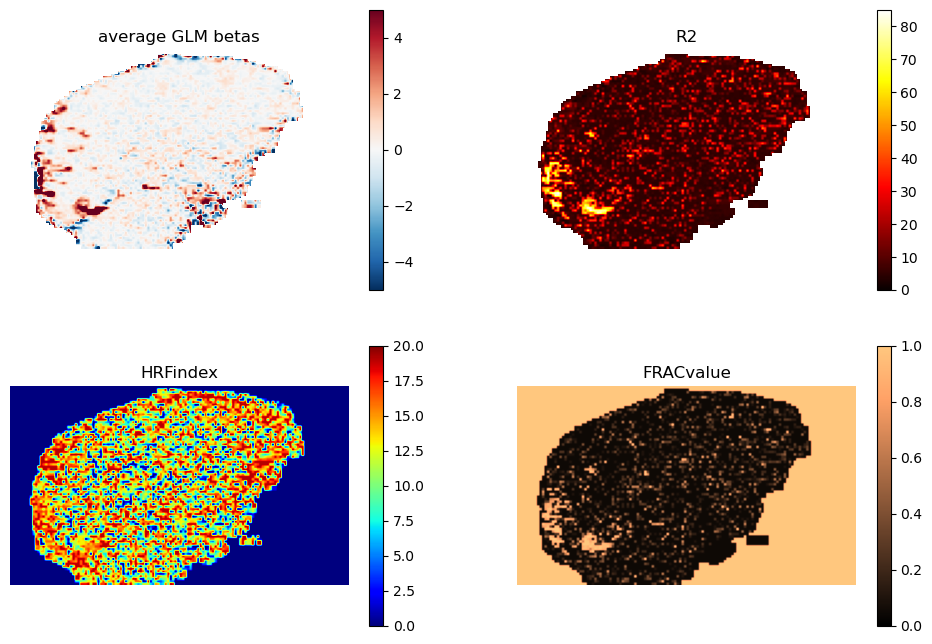

In [12]:
# we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# which contains the full set of GLMsingle optimizations.

# we will plot betas, R2, optimal HRF indices, and the voxel frac values
plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
colormaps = ['RdBu_r','hot','jet','copper']
clims = [[-5,5],[0,85],[0,20],[0,1]]

plt.figure(figsize=(12,8))

for i in range(len(plot_fields)):
    
    plt.subplot(2,2,i+1)
    
    if i == 0:
        # when plotting betas, for simplicity just average across all image presentations
        # this will yield a summary of whether voxels tend to increase or decrease their 
        # activity in response to the experimental stimuli (similar to outputs from 
        # an ONOFF GLM)
        plot_data = np.nanmean(results_glmsingle['typed'][plot_fields[i]].reshape(136,136,80,152),3)[55,:,:].T
        print(plot_data.shape)
        titlestr = 'average GLM betas'
    
    else:
        # plot all other voxel-wise metrics as outputted from GLMsingle
        plot_data = results_glmsingle['typed'][plot_fields[i]].reshape(136,136,80)[55,:,:].T
        titlestr = plot_fields[i]
    
    plt.imshow(plot_data,cmap=colormaps[i],clim=clims[i], origin="lower")
    plt.colorbar()
    plt.title(titlestr)
    plt.axis(False)

In [ ]:
slices = results_glmsingle['typed']['betasmd'].shape[2]
mean_betas=np.nanmean(results_glmsingle['typed']['betasmd'],3)
fi, axs = plt.subplots(int(slices/4), 4, sharex=True, sharey=True, figsize=(8,32), layout='constrained')
rows = range(int(slices/4))
cols = range(4)
s = 0
for r in rows:
    for c in cols:
        axs[r][c].imshow(mean_betas[:,:,s], cmap='RdBu_r', clim=[-5,5])
        axs[r][c].set_title(str(s))
        s += 1

end = results_glmsingle['typed']['betasmd'].shape[1]
slices = np.arange(9,end-9,3)
rows = range(int(len(slices)/3))
cols = range(3)
mean_betas=np.nanmean(results_glmsingle['typed']['betasmd'],3)
fi, axs = plt.subplots(len(rows), 3, sharex=True, sharey=True, figsize=(8,32), layout='constrained')

s = 0
for r in rows:
    for c in cols:
        axs[r][c].imshow(mean_betas[:,slices[s],:], cmap='RdBu_r', clim=[-5,5])
        axs[r][c].set_title(str(slices[s]))
        s += 1

end = results_glmsingle['typed']['betasmd'].shape[1]
slices = np.arange(12,end-12,3)
rows = range(int(len(slices)/3))
cols = range(3)
mean_betas=np.nanmean(results_glmsingle['typed']['betasmd'],3)
fi, axs = plt.subplots(len(rows), 3, sharex=True, sharey=True, figsize=(8,32), layout='constrained')

s = 0
for r in rows:
    for c in cols:
        axs[r][c].imshow(mean_betas[slices[s],:,:], cmap='RdBu_r', clim=[-5,5])
        axs[r][c].set_title(str(slices[s]))
        s += 1

slices = results_glmsingle['typea']['betasmd'].shape[2]
fi, axs = plt.subplots(int(slices/4), 4, sharex=True, sharey=True, figsize=(8,32), layout='constrained')
rows = range(int(slices/4))
cols = range(4)
s = 0
for r in rows:
    for c in cols:
        axs[r][c].imshow(results_glmsingle['typea']['betasmd'][:,:,s], cmap='RdBu_r', clim=[-5,5])
        axs[r][c].set_title(str(s))
        s += 1

In [13]:
# consolidate design matrices
designALL = np.concatenate(designs,axis=0)

# construct a vector containing 0-indexed condition numbers in chronological order
corder = []
for p in range(designALL.shape[0]):
    if np.any(designALL[p]):
        corder.append(np.argwhere(designALL[p])[0,0])
        
corder = np.array(corder)

In [14]:
corder

array([203, 466, 158, 277, 457, 243, 465, 203, 158, 244, 278,  56, 337,
        91, 355, 338,  56,  91,  75, 356, 457, 296, 110, 296, 108,  75,
       389, 378, 268, 141, 388, 141, 457, 380, 267,  23, 197, 159, 444,
        21,  49, 316, 197, 445, 161, 315,  48, 122, 375, 170, 121, 440,
       237, 377, 118, 238, 170, 119, 439, 138,  41, 140, 457, 368,  41,
       368, 365, 234, 364, 271, 128,  60, 236, 127,  60, 272, 341, 420,
        25,  79, 484, 422, 483, 339, 457,  25,  79,  73, 457, 452, 289,
       229, 457,  72, 290, 450, 229, 218, 248, 218, 246, 403, 263, 402,
       115, 291, 492, 256, 262, 492, 115, 293, 257,  33, 146,  35, 360,
       487, 145, 213, 480, 360,   8, 486, 214, 481,   8, 459, 320, 431,
       111, 459, 457, 320, 112, 174, 429,  70, 175, 260,  70, 326, 260,
       264, 199, 266, 131, 314, 325, 129, 313, 198], dtype=int64)

In [15]:
corder.shape

(152,)

In [16]:
# in order to compute split-half reliability, we have to do some indexing.
# we want to find images with least two repetitions and then prepare a
# useful matrix of indices that refer to when these occur.

repindices = [] # 2 x images containing stimulus trial indices.

# the first row refers to the first presentation; the second row refers to
# the second presentation.
for p in range(designALL.shape[1]): # loop over every condition
    
    temp = np.argwhere(corder==p)[:,0] # find indices where this condition was shown
    
    # note that for conditions with 3 presentations, we are simply ignoring the third trial
    if len(temp) >= 2:
        repindices.append([temp[0], temp[1]]) 

repindices = np.vstack(np.array(repindices)).T 
repindices.shape

(2, 25)

In [ ]:
repindices

In [20]:
# read mask image

mask_folder = op.join(base_folder, '01_MRI', 'ANTS_REG', 'ROIs', subj)
mask_file = 'C-mask_' + subj + '_right_CA3DG-To-meanFunc.nii.gz'
fname = op.join(mask_folder, mask_file)
img = nib.load(fname)
roi = img.get_fdata()

(136, 136, 80, 460)


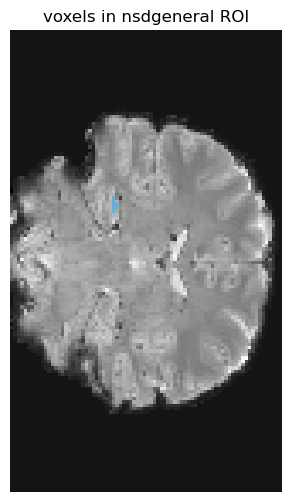

In [21]:
r_ca3dg = roi.astype(float)

# convert voxels outside ROI to nan for overlay plotting
r_ca3dg[r_ca3dg==0] = np.nan 

# get mean fMRI volume from run 1
xyzt = (136,136,80,460)
print(xyzt)
meanvol = np.mean(data[0].reshape(xyzt),axis=3)

# plot ROI on top of overlay
plt.figure(figsize=(12,6))
plt.imshow(meanvol[:,63,:],cmap='gray')
plt.imshow(r_ca3dg[:,63,:],cmap='Blues',clim=(0,2))

plt.title('voxels in nsdgeneral ROI')
plt.box(False)
plt.axis(False);

(136, 136, 80, 460)


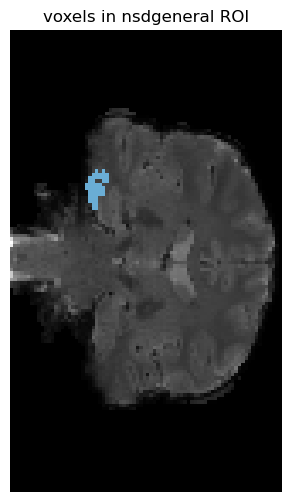

In [22]:
# read mask image
mask_file = 'C-mask_' + subj + '_right_PRC-To-meanFunc.nii.gz'
fname = op.join(mask_folder, mask_file)
img = nib.load(fname)
roi = img.get_fdata()

r_prc = roi.astype(float)

# convert voxels outside ROI to nan for overlay plotting
r_prc[r_prc==0] = np.nan 

# get mean fMRI volume from run 1
xyzt = (136,136,80,460)
print(xyzt)
meanvol = np.mean(data[0].reshape(xyzt),axis=3)

# plot ROI on top of overlay
plt.figure(figsize=(12,6))
plt.imshow(meanvol[:,70,:],cmap='gray')
plt.imshow(r_prc[:,70,:],cmap='Blues',clim=(0,2))

plt.title('voxels in nsdgeneral ROI')
plt.box(False)
plt.axis(False);

In [23]:
# create dictionary containing the GLM betas from the four different models we will compare.
# note that the "assume hrf" betas come from the "typeb" field of our baseline GLM
# (with HRF fitting turned off), and that the "fit hrf" betas also come from 
# the "typeb" field of the GLM that ran with all default GLMsingle routines
# enabled

models = dict()
models['fithrf'] = results_glmsingle['typeb']['betasmd'].reshape(136,136,80,152)
models['fithrf_glmdenoise'] = results_glmsingle['typec']['betasmd'].reshape(136,136,80,152)
models['fithrf_glmdenoise_rr'] = results_glmsingle['typed']['betasmd'].reshape(136,136,80,152)

In [24]:
# finally, let's compute split-half reliability. we are going to loop
# through our 4 models and calculate split-half reliability for each of them

vox_reliabilities = [] # output variable for reliability values

modelnames = list(models.keys())

# for each beta version...
for m in range(len(modelnames)):
    
    print(f'computing reliability for beta version: {modelnames[m]}')
    time.sleep(1)
    
    # get the repeated-condition GLM betas using our repindices variable
    betas = models[modelnames[m]][:,:,:,repindices] # automatically reshapes to (X x Y x Z x 2 x nConditions)
    x,y,z = betas.shape[:3] 
    
    rels = np.full((x,y,z),np.nan)
    
    # loop through voxels in the 3D volume...
    for xx in tqdm(range(x)):
        for yy in range(y):
            for zz in range(z):
                
                # reliability at a given voxel is pearson correlation between response profiles from first and 
                # second image presentations (dim = 25 repeated conditions)
                rels[xx,yy,zz] = np.corrcoef(betas[xx,yy,zz,0],
                                             betas[xx,yy,zz,1])[1,0]
          
    vox_reliabilities.append(rels)


computing reliability for beta version: fithrf


100%|██████████| 136/136 [01:37<00:00,  1.39it/s]


computing reliability for beta version: fithrf_glmdenoise


100%|██████████| 136/136 [01:34<00:00,  1.44it/s]


computing reliability for beta version: fithrf_glmdenoise_rr


100%|██████████| 136/136 [01:33<00:00,  1.45it/s]


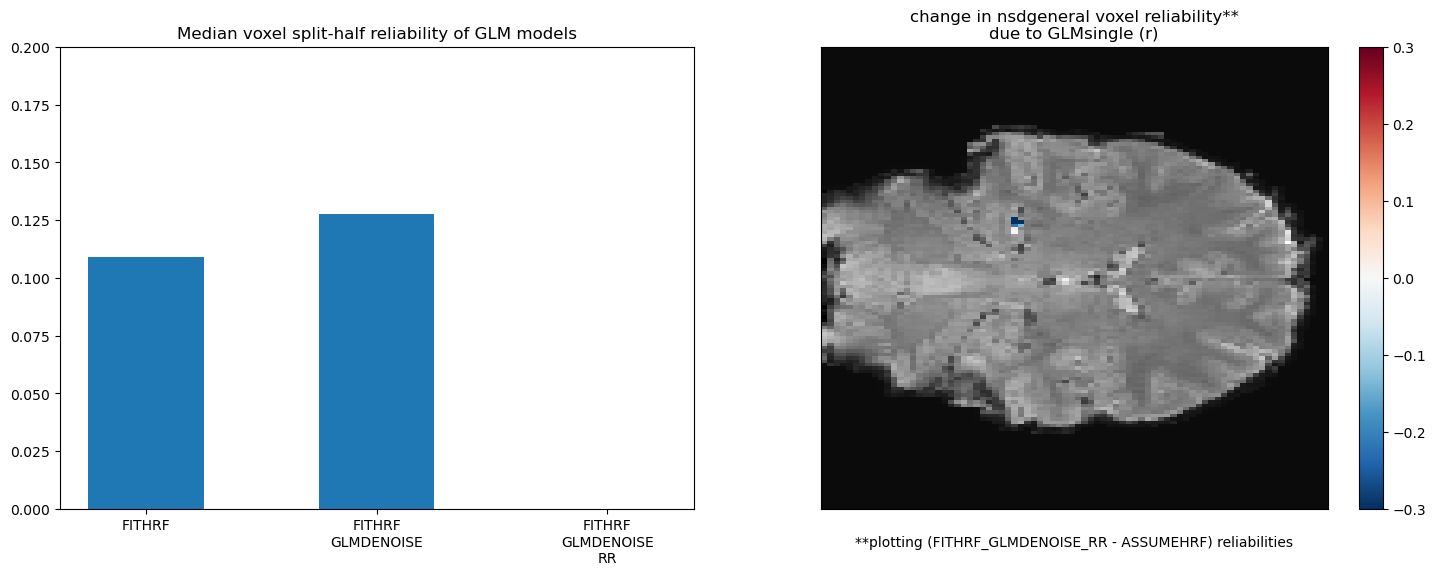

In [26]:
# for each GLM we will calculate median reliability for voxels within the
# nsdgeneral visual ROI and compare using a bar graph

comparison = []
for vr in vox_reliabilities:
    comparison.append(np.nanmedian(vr[r_ca3dg==1]))

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.bar(np.arange(len(comparison)),comparison,width=0.5)
plt.title('Median voxel split-half reliability of GLM models')
plt.xticks(np.arange(len(comparison)),np.array(['FITHRF', 'FITHRF\nGLMDENOISE', 'FITHRF\nGLMDENOISE\nRR']));
plt.ylim([0.0,0.2])

# draw plot showing the change in reliability between the baseline GLM
# and the final output of GLMsingle (fithrf-glmdenoise-RR betas)
vox_improvement = np.squeeze(vox_reliabilities[-1] - vox_reliabilities[0])
vox_improvement[r_ca3dg != 1] = np.nan

plt.subplot(122)
plt.imshow(meanvol[:,60,:],cmap='gray',aspect='auto')
plt.imshow(vox_improvement[:,60,:],cmap='RdBu_r',clim=(-0.3,0.3),aspect='auto')
plt.colorbar()
plt.title('change in nsdgeneral voxel reliability**\ndue to GLMsingle (r)')
plt.xticks([])
plt.yticks([])
plt.xlabel('\n**plotting (FITHRF_GLMDENOISE_RR - ASSUMEHRF) reliabilities');

# notice that there is systematic increase in reliability moving from the
# first to the second to the third to the final fourth version of the GLM
# results. these increases reflect, respectively, the addition of HRF
# fitting, the derivation and use of data-driven nuisance regressors, and
# the use of ridge regression as a way to regularize the instability of
# closely spaced experimental trials. depending on one's experimental
# goals, it is possible with setting of option flags to activate a subset
# of these analysis features.

# also, keep in mind that in the above figure, we are simply showing the
# median as a metric of the central tendency (you may want to peruse
# individual voxels in scatter plots, for example).

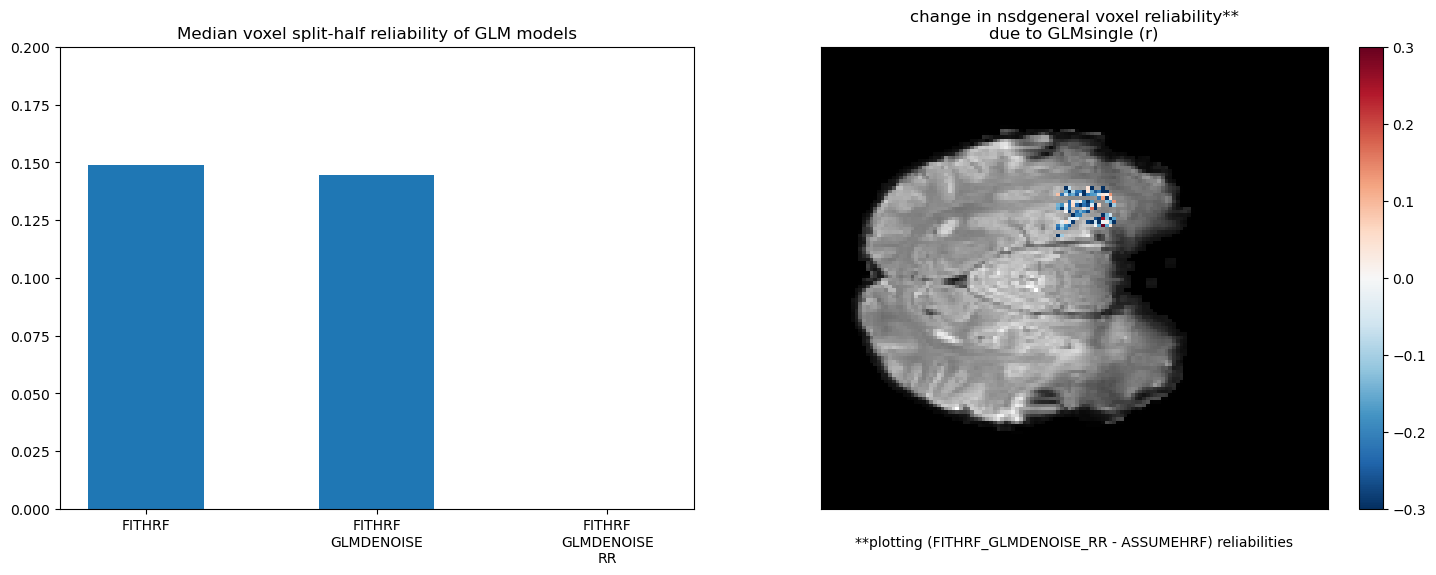

In [27]:
# for each GLM we will calculate median reliability for voxels within the
# nsdgeneral visual ROI and compare using a bar graph

comparison = []
for vr in vox_reliabilities:
    comparison.append(np.nanmedian(vr[r_prc==1]))
   

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.bar(np.arange(len(comparison)),comparison,width=0.5)
plt.title('Median voxel split-half reliability of GLM models')
plt.xticks(np.arange(len(comparison)),np.array(['FITHRF', 'FITHRF\nGLMDENOISE', 'FITHRF\nGLMDENOISE\nRR']));
plt.ylim([0.0,0.2])

# draw plot showing the change in reliability between the baseline GLM
# and the final output of GLMsingle (fithrf-glmdenoise-RR betas)
vox_improvement = np.squeeze(vox_reliabilities[-1] - vox_reliabilities[0])
vox_improvement[r_prc != 1] = np.nan

plt.subplot(122)
plt.imshow(meanvol[:,:,26],cmap='gray',aspect='auto')
plt.imshow(vox_improvement[:,:,26],cmap='RdBu_r',clim=(-0.3,0.3),aspect='auto')
plt.colorbar()
plt.title('change in nsdgeneral voxel reliability**\ndue to GLMsingle (r)')
plt.xticks([])
plt.yticks([])
plt.xlabel('\n**plotting (FITHRF_GLMDENOISE_RR - ASSUMEHRF) reliabilities');

# notice that there is systematic increase in reliability moving from the
# first to the second to the third to the final fourth version of the GLM
# results. these increases reflect, respectively, the addition of HRF
# fitting, the derivation and use of data-driven nuisance regressors, and
# the use of ridge regression as a way to regularize the instability of
# closely spaced experimental trials. depending on one's experimental
# goals, it is possible with setting of option flags to activate a subset
# of these analysis features.

# also, keep in mind that in the above figure, we are simply showing the
# median as a metric of the central tendency (you may want to peruse
# individual voxels in scatter plots, for example).

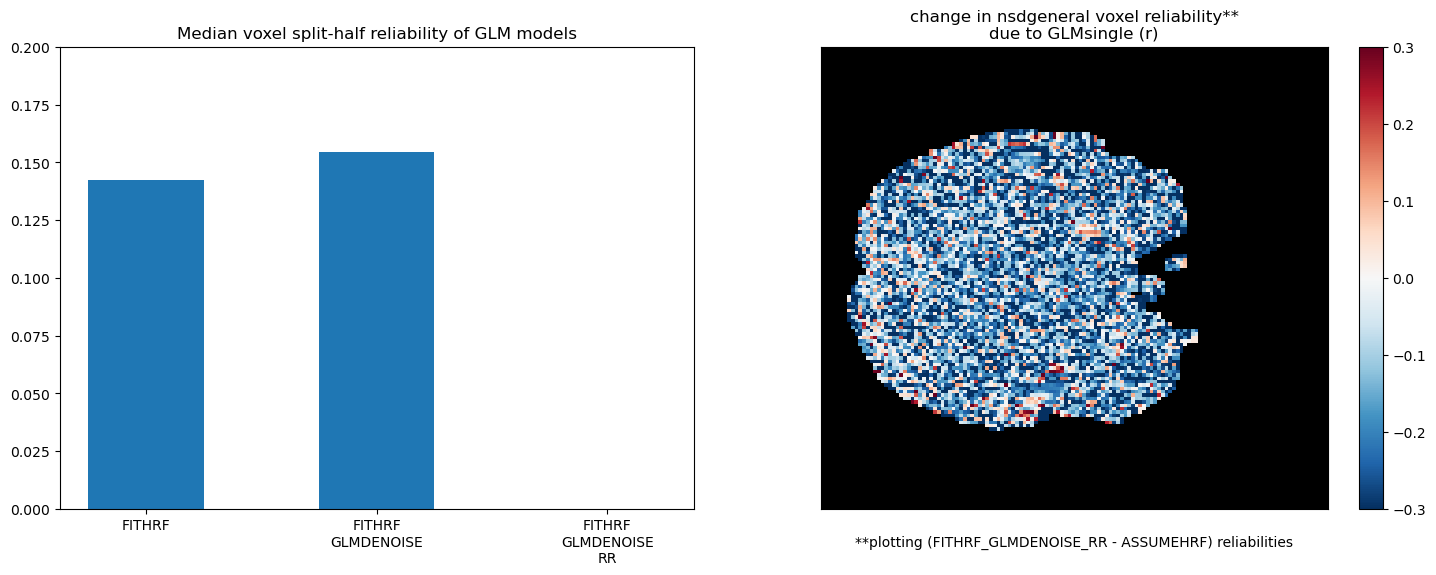

In [28]:
# for each GLM we will calculate median reliability for voxels within the
# nsdgeneral visual ROI and compare using a bar graph

comparison = []
for vr in vox_reliabilities:
    comparison.append(np.nanmedian(vr))
   

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.bar(np.arange(len(comparison)),comparison,width=0.5)
plt.title('Median voxel split-half reliability of GLM models')
plt.xticks(np.arange(len(comparison)),np.array(['FITHRF', 'FITHRF\nGLMDENOISE', 'FITHRF\nGLMDENOISE\nRR']));
plt.ylim([0.0,0.2])

# draw plot showing the change in reliability between the baseline GLM
# and the final output of GLMsingle (fithrf-glmdenoise-RR betas)
vox_improvement = np.squeeze(vox_reliabilities[-1] - vox_reliabilities[0])
#vox_improvement[r_prc != 1] = np.nan

plt.subplot(122)
plt.imshow(meanvol[:,:,24],cmap='gray',aspect='auto')
plt.imshow(vox_improvement[:,:,24],cmap='RdBu_r',clim=(-0.3,0.3),aspect='auto')
plt.colorbar()
plt.title('change in nsdgeneral voxel reliability**\ndue to GLMsingle (r)')
plt.xticks([])
plt.yticks([])
plt.xlabel('\n**plotting (FITHRF_GLMDENOISE_RR - ASSUMEHRF) reliabilities');

# notice that there is systematic increase in reliability moving from the
# first to the second to the third to the final fourth version of the GLM
# results. these increases reflect, respectively, the addition of HRF
# fitting, the derivation and use of data-driven nuisance regressors, and
# the use of ridge regression as a way to regularize the instability of
# closely spaced experimental trials. depending on one's experimental
# goals, it is possible with setting of option flags to activate a subset
# of these analysis features.

# also, keep in mind that in the above figure, we are simply showing the
# median as a metric of the central tendency (you may want to peruse
# individual voxels in scatter plots, for example).

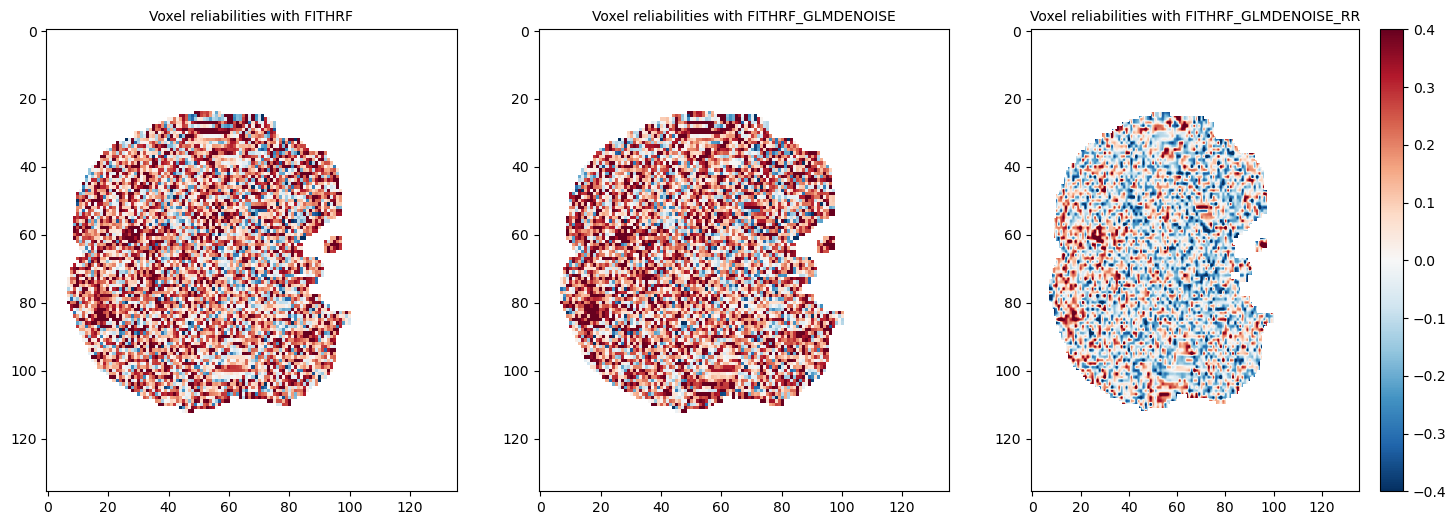

In [29]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(vox_reliabilities[0][:,:,24],cmap='RdBu_r',clim=(-0.3,0.3),aspect='auto', vmin=-0.4,vmax=0.4)
plt.title('Voxel reliabilities with FITHRF', fontsize=10)
plt.subplot(132)
plt.imshow(vox_reliabilities[1][:,:,24],cmap='RdBu_r',clim=(-0.3,0.3),aspect='auto', vmin=-0.4,vmax=0.4)
plt.title('Voxel reliabilities with FITHRF_GLMDENOISE', fontsize=10)
plt.subplot(133)
plt.imshow(vox_reliabilities[2][:,:,24],cmap='RdBu_r',clim=(-0.3,0.3),aspect='auto', vmin=-0.4,vmax=0.4)
plt.title('Voxel reliabilities with FITHRF_GLMDENOISE_RR', fontsize=10)
plt.colorbar()

In [ ]:
comparison[2]

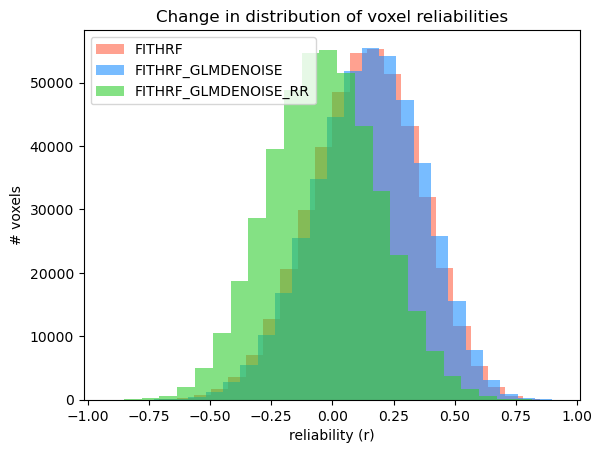

In [30]:
plt.hist(vox_reliabilities[0].reshape(-1),25,alpha=0.6,color='tomato');
plt.hist(vox_reliabilities[1].reshape(-1),25,alpha=0.6,color='dodgerblue');
plt.hist(vox_reliabilities[2].reshape(-1),25,alpha=0.6,color='limegreen');
plt.xlabel('reliability (r)')
plt.ylabel('# voxels')
plt.legend(['FITHRF', 'FITHRF_GLMDENOISE', 'FITHRF_GLMDENOISE_RR'])
plt.title('Change in distribution of voxel reliabilities');

In [43]:
repindices

array([[122,  78,  60,  11,  71, 137,  18,  79,  13, 104,  29,   2,  49,
         36,   0,  97,  91, 139,  21, 128, 116,  63,   4, 127, 106],
       [126,  85,  64,  16,  74, 140,  25,  86,  17, 110,  31,   8,  56,
         42,   7,  99,  96, 142,  23, 133, 121,  65,  20, 131, 109]],
      dtype=int64)

In [44]:
corder

array([203, 466, 158, 277, 457, 243, 465, 203, 158, 244, 278,  56, 337,
        91, 355, 338,  56,  91,  75, 356, 457, 296, 110, 296, 108,  75,
       389, 378, 268, 141, 388, 141, 457, 380, 267,  23, 197, 159, 444,
        21,  49, 316, 197, 445, 161, 315,  48, 122, 375, 170, 121, 440,
       237, 377, 118, 238, 170, 119, 439, 138,  41, 140, 457, 368,  41,
       368, 365, 234, 364, 271, 128,  60, 236, 127,  60, 272, 341, 420,
        25,  79, 484, 422, 483, 339, 457,  25,  79,  73, 457, 452, 289,
       229, 457,  72, 290, 450, 229, 218, 248, 218, 246, 403, 263, 402,
       115, 291, 492, 256, 262, 492, 115, 293, 257,  33, 146,  35, 360,
       487, 145, 213, 480, 360,   8, 486, 214, 481,   8, 459, 320, 431,
       111, 459, 457, 320, 112, 174, 429,  70, 175, 260,  70, 326, 260,
       264, 199, 266, 131, 314, 325, 129, 313, 198], dtype=int64)

In [45]:
corder[repindices[0]]

array([  8,  25,  41,  56,  60,  70,  75,  79,  91, 115, 141, 158, 170,
       197, 203, 218, 229, 260, 296, 320, 360, 368, 457, 459, 492],
      dtype=int64)

In [70]:
timing1 = []
timing2 = []
for rep in repindices[0]:
    t1 = np.where(designALL[:,corder[rep]]==1)[0][0]
    t2 = np.where(designALL[:,corder[rep]]==1)[0][1]
    timing1.append(t1)
    timing2.append(t2)
timing= np.array([timing1, timing2])

In [74]:
abs(repindices[1]-repindices[0])

array([ 4,  7,  4,  5,  3,  3,  7,  7,  4,  6,  2,  6,  7,  6,  7,  2,  5,
        3,  2,  5,  5,  2, 16,  4,  3], dtype=int64)

In [76]:
abs(timing[1]-timing[0])

array([18, 32, 17, 26, 18, 13, 37, 37, 20, 29, 10, 35, 40, 30, 42, 16, 25,
       12, 16, 28, 27,  8, 84, 23, 15], dtype=int64)

In [85]:
temporal_distance = abs(timing[1]-timing[0])
print('mean', np.mean(temporal_distance))
print('median',np.median(temporal_distance))
print('min',np.min(temporal_distance))
print('max',np.max(temporal_distance))

mean 26.32
median 25.0
min 8
max 84


In [84]:
tr_distance = abs(timing[1]-timing[0])/1.84
print('mean', np.mean(tr_distance))
print('median',np.median(tr_distance))
print('min',np.min(tr_distance))
print('max',np.max(tr_distance))

mean 14.304347826086957
median 13.586956521739129
min 4.3478260869565215
max 45.65217391304348


(array([5., 7., 6., 4., 2., 0., 0., 0., 0., 1.]),
 array([ 4.34782609,  8.47826087, 12.60869565, 16.73913043, 20.86956522,
        25.        , 29.13043478, 33.26086957, 37.39130435, 41.52173913,
        45.65217391]),
 <BarContainer object of 10 artists>)

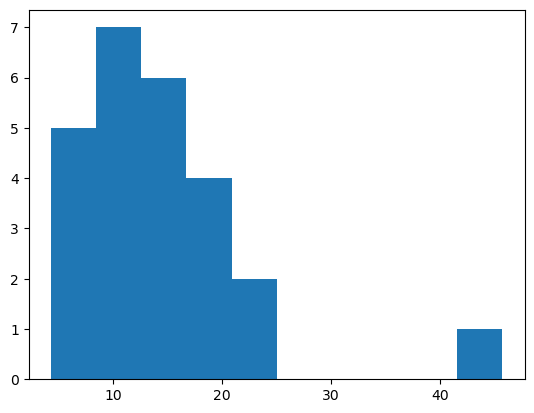

In [87]:
plt.hist(tr_distance)

In [ ]:
# further todos for RSA

# read all roi masks
# calculate correlation between all erp pairs and lure pairs and out-of triplet random image (and compare between ROIs)

# create correlation matrix between all images (some images may never be shown to subject during encoding)